## <a id="Top" style="color:black;">Top</a>
- [Plotting BH evaporation](#BHevap)
- [Fitting the Lightcurves of GRB candidates](#lightcurves)
- [Expanding to other sources](#candidates)
- [Batch fit all sources with a GBM or LLE t90 less than 2s](#batchfit2s)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import ultranest

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, norm

from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

from threeML.io.package_data import get_path_of_data_file

import warnings
warnings.simplefilter("ignore")

Welcome to JupyROOT 6.22/02


10:34:20 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=564018;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=674244;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/functions.py#49\49]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=766527;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=785998;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/functions.py#70\70]8;;\
                  will not be available.                                                                           

10:34:21 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=112324;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=940120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/functions/functions_1D/absorption.py#37\37]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=828520;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=968011;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=923387;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=82472;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=911689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=111483;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=400070;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=556301;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=849724;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=54243;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

10:34:22 WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=837769;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=390956;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/astromodels/core/parameter.py#706\706]8;;\

10:34:22 INFO      Starting 3ML!                                                                     ]8;id=726409;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=123873;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#31\31]8;;\

10:34:28 WARNING   Multinest minimizer not available                                           ]8;id=734120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=776163;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

10:34:29 WARNING   PyGMO is not available                                                      ]8;id=216661;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=988491;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

10:34:30 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=766738;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=886334;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#80\80]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=633678;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=149361;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#130\130]8;;\
                  software installed and configured?                                                               

10:34:34 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=110101;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=717974;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#343\343]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=946801;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=161742;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#343\343]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=866309;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=71351;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/__init__.py#343\343]8;;\
                  performances in 3ML                                                                              

In [2]:
# EBH Plotting
def afterglow(tau, delta, t_m, t_p, normalization):
    """
    Afterglow model.
    """
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization* ( 
        np.exp(-(1/t_p)*(tau - delta)) /
        (1 + np.exp(-(1/t_m)*(tau - delta))) )

# Simplifying lightcurve with powerlaw of index -.52
def simplified_lightcurve(tau, normalization = 1., index = .52, delta=0):
    """
    Simplified lightcurve model.

    Form 
    """
    f = normalization*(-tau + delta)**(-index)
    for i, val in enumerate(f):
        if np.isnan(val) or np.isinf(val):
            break
    f[i:] = 0
    return f

### <a id="BHevap" style="color:black;">Plotting BH evaporation</a>
[back to top](#Top)

In [3]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV

"""
def afterglow(tau, delta, t_m, t_p, normalization):
    """
    #Afterglow model.
    """
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization* ( 
        np.exp(-(1/t_p)*(tau - delta)) /
        (1 + np.exp(-(1/t_m)*(tau - delta))) )

# Simplifying lightcurve with powerlaw of index -.52
def simplified_lightcurve(tau, normalization = 1., index = .52, delta=0):
    """
    #Simplified lightcurve model.

    #Form 
    """
    f = normalization*(-tau + delta)**(-index)
    for i, val in enumerate(f):
        if np.isnan(val) or np.isinf(val):
            break
    f[i:] = 0
    return f
"""

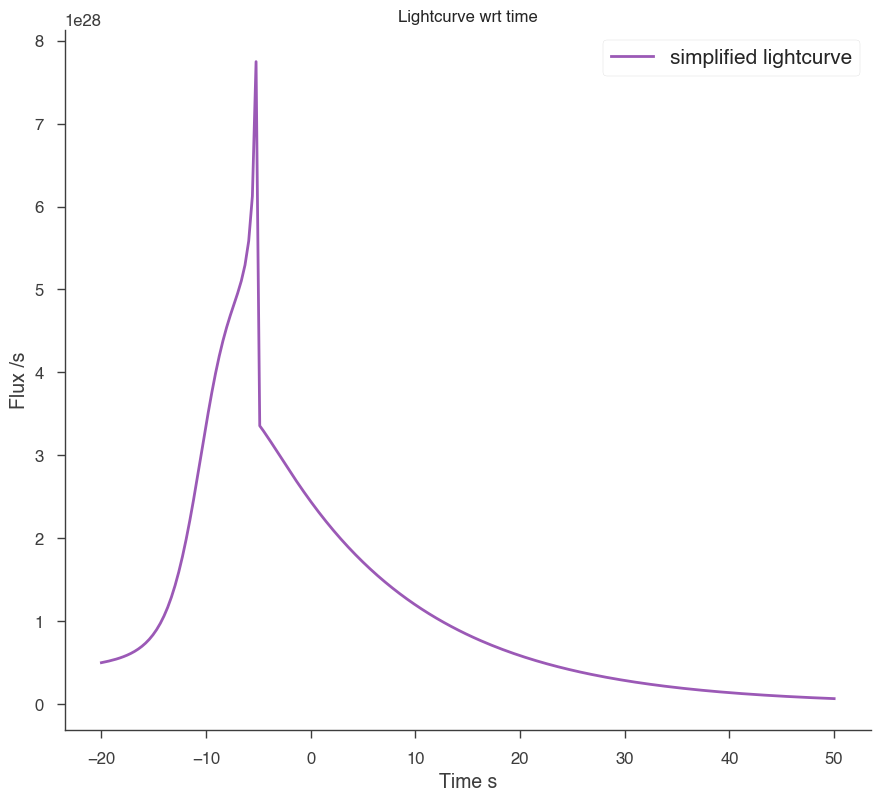

In [63]:
tau = np.linspace(-20,50,200)

curve = np.zeros(200)

fig, ax = plt.subplots()

curve = curve + simplified_lightcurve(tau, normalization = 2*1e28, delta = -5)

curve = curve + afterglow(tau, -10, 1.5, 14, 5*1e28)

ax.plot(tau, curve, label = 'simplified lightcurve')

#ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

### <a id="dl_lc" style="color:black;">Downloading lightcurves</a>
[back to top](#Top)

In [14]:
# Import the new data, fit it with the same plaw+afterglow model

param_names = ['lc_K', 'lc_index', 'lc_delta'] 
#'ag_K', 'ag_t_m', 'ag_t_p', 'ag_delta']

def lightcurve_model(params):

    # Retrieve new parameters
    (lc_K, lc_index, lc_delta, 
    ag_K, ag_t_m, ag_t_p, ag_delta) = params

    # Instantiate blank model
    model = np.zeros(len(data))

    # Create lc from simplified powerlaw model.
    model = model + simplified_lightcurve(tau = time,
     normalization = lc_K, index = lc_index, delta = lc_delta)

    # Create ag.
    model = model + afterglow(tau=time,
     normalization=ag_K, t_m = ag_t_m, t_p = ag_t_p, delta = ag_delta)

    return model

poisson_likelihood_model = lambda params: -0.5 * ((
    (simplified_lightcurve(time, params[0], params[1], params[2]) - data)
    /(1e-2*data)) **2).sum()

likelihood_model = lambda params: -0.5 * ((
    (simplified_lightcurve(time, params[0], params[1], params[2]) - data)
    /(0.01*np.median(data))) **2).sum()

# GRB 140206275

In [17]:
# Load and process data

LAT_14_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/LAT_GRB140206275')

# Select bounds
LAT_signal_bounds = (0.,25.)
LAT_index_bounds = [np.argmin(np.abs(np.array(LAT_14_data['Start'])-i)) for i in LAT_signal_bounds]

# Snippet
time = LAT_14_data['Start'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()
data = LAT_14_data['Counts'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()

# Shift down for bkg
LAT_sub = data.min()

# Bring down to min
data -= LAT_sub

# Pack it away for plotting later
LAT_14_selection = {
    'Dataset': LAT_14_data,
    'Time': time,
    'Index bounds': LAT_index_bounds,
    'Min sub': LAT_sub
}

####
def prior_14_LLE(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1e1
    hi = 1e3
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .372
    lo = .525
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 8
    lo = 10
    params[2] = cube[2] * (hi - lo) + lo

    return params
###

# def prior_14_LLE(cube):
#     params = cube.copy()

#     lo = 1e1
#     hi = 1e3
#     params[0] = cube[0] * (hi - lo) + lo

#     hi = 8
#     lo = 10
#     params[1] = cube[1] * (hi - lo) + lo


# latindex_poisson = lambda params: -0.5 * ((
#     np.divide(simplified_lightcurve(time, params[0], 0.37, params[1]) - data),
#     (1e-1*data)) **2).sum()

# param_names = ['lc_K', 'lc_delta']

if True:
    sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_14_LLE)

    result = sampler.run()
    sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+05  ..-215706.51 [-215706.6462..-215706.6461]*| it/evals=10680/20859 eff=52.2020% N=400 
[ultranest] Likelihood function evaluations: 20871
[ultranest]   logZ = -2.157e+05 +- 0.2039
[ultranest] Effective samples strategy satisfied (ESS = 2097.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.22 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -215728.715 +- 0.410
  single instance: logZ = -215728.715 +- 0.225
  bootstrapped   : logZ = -215728.669 +- 0.410
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 71.15 │ ▁▁ ▁▁▁▁▁▁▂▂▃▄▄▆▇▇▇▇▆▆▅▅▃▃▂▁▁▁▁▁▁▁▁  ▁ │72.95     72.02 +- 0.20
    lc_index            : 0.524776│▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▅▆▇│0.525000    0.524974 +-

In [24]:
# Load and process data

GBM_14_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/GBM_GRB140206275')

# Select bounds
GBM_signal_bounds = (-5.,40.)
GBM_index_bounds = [np.argmin(np.abs(np.array(GBM_14_data['Start'])-i)) for i in GBM_signal_bounds]

# Snippet
time = GBM_14_data['Start'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()
data = GBM_14_data['AvgCounts'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()

# Shift down for bkg
GBM_sub = data.min()

# Bring down to min
data -= GBM_sub

# Pack it away for plotting later
GBM_14_selection = {
    'Dataset': GBM_14_data,
    'Time': time,
    'Index bounds': GBM_index_bounds,
    'Min sub': GBM_sub
}

def prior_14_GBM(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1e1
    hi = 1e3
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .372
    lo = .344
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 10
    lo = 15
    params[2] = cube[2] * (hi - lo) + lo

    return params

if True:
    sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_14_GBM)

    result = sampler.run()
    sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+06  95..-2727389.68 [-2727389.9473..-2727389.9471]*| it/evals=14614/26534 eff=55.9195% N=400 
[ultranest] Likelihood function evaluations: 26547
[ultranest]   logZ = -2.727e+06 +- 0.264
[ultranest] Effective samples strategy satisfied (ESS = 2382.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.20 to 0.62, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.26 tail:0.01 total:0.26 required:<0.50
[ultranest] done iterating.

logZ = -2727421.809 +- 0.538
  single instance: logZ = -2727421.809 +- 0.272
  bootstrapped   : logZ = -2727421.825 +- 0.538
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 230.56│ ▁▁▁▁▁▁▁▁▂▂▃▄▄▆▆▇▇▇▇▅▅▅▃▃▂▁▁▁▁▁▁▁▁▁▁ ▁ │231.72    231.09 +- 0.13
    lc_index            : 0.3719831│ ▁       ▁  ▁▁ ▁▁▁▁▁▁▁▁▁

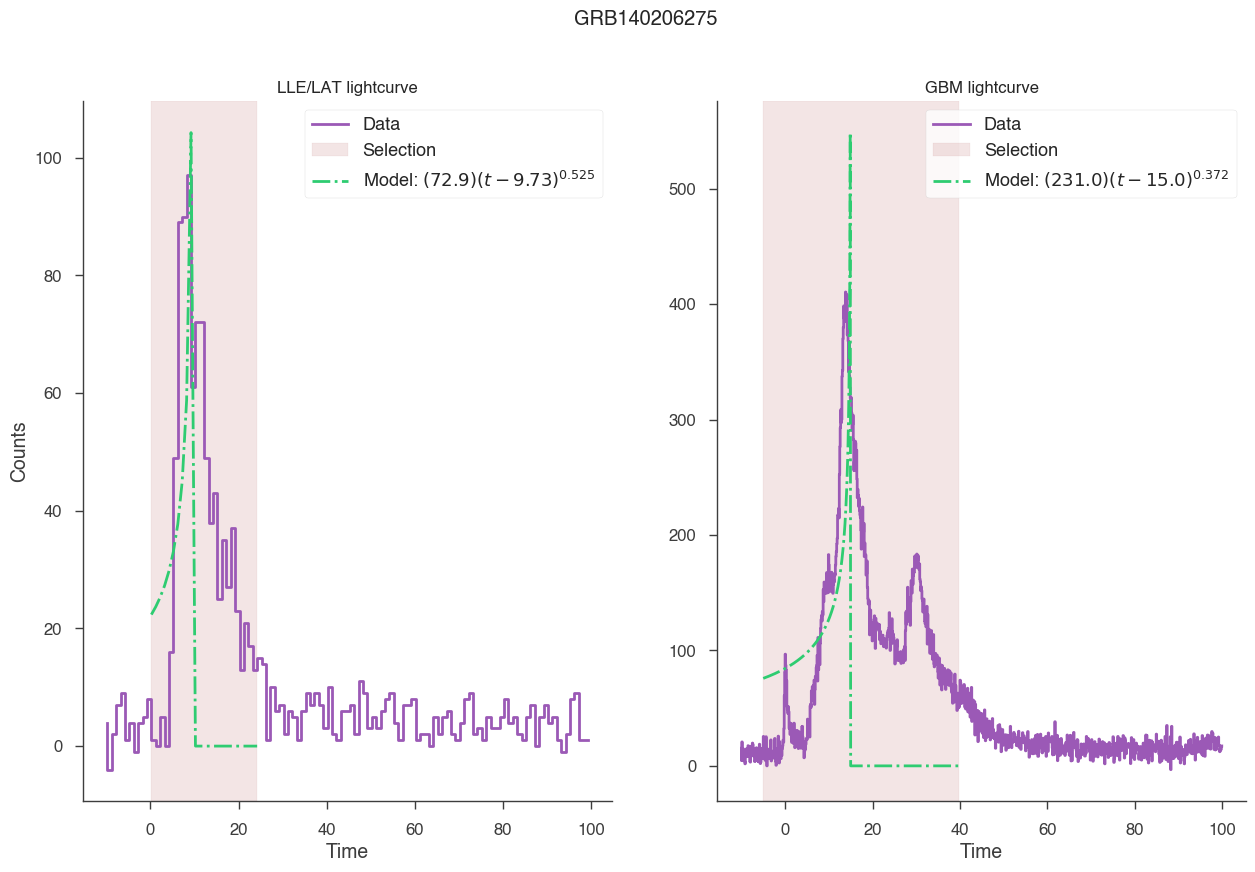

In [26]:
fig, ax = plt.subplots(1,2)

# Plot LLE data
ax[0].step(LAT_14_data['Start'], LAT_14_data['Counts'] - LAT_14_selection['Min sub'], label = 'Data')
ax[0].axvspan(LAT_14_selection['Time'].iloc[0], LAT_14_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred', label = 'Selection')



# Plot GBM data
ax[1].step(GBM_14_data['Start'], GBM_14_data['AvgCounts'] - GBM_14_selection['Min sub'], label = 'Data')
ax[1].axvspan(GBM_14_selection['Time'].iloc[0], GBM_14_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred', label = 'Selection')


# Plot LAT model
results = 72.9, .525, 9.73 #94.5, 0.76, 10.
model = simplified_lightcurve(LAT_14_selection['Time'], *results)#100.5, .771, 10)
labelstr = r'Model: $(%s)(t-%s)^{%s}}$'%(results[0], results[2], results[1])
ax[0].plot(LAT_14_selection['Time'], model, '-.', label = labelstr)

# Plot GBM model 
results = 231., .372, 15. #242, .445, 15.
model = simplified_lightcurve(GBM_14_selection['Time'], *results)#240, .46, 14.99)
labelstr = r'Model: $(%s)(t-%s)^{%s}}$'%(results[0], results[2], results[1])
ax[1].plot(GBM_14_selection['Time'], model, '-.', label = labelstr)


fig.set_figwidth(15)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_title('LLE/LAT lightcurve')
ax[1].set_title('GBM lightcurve')

fig.suptitle('GRB140206275')
fig.savefig('Fitted_GRB140206275.png', dpi=500)

# GRB 130821674

In [27]:
LAT_13_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/LAT_GRB130821674')

# Select bounds
LAT_signal_bounds = (20.,40.)
LAT_index_bounds = [np.argmin(np.abs(np.array(LAT_13_data['Start'])-i)) for i in LAT_signal_bounds]

# Snippet
time = LAT_13_data['Start'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()
data = LAT_13_data['Counts'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()

# Shift down for bkg
LAT_sub = data.min()

# Bring down to min
data -= LAT_sub

# Pack it away for plotting later
LAT_13_selection = {
    'Dataset': LAT_13_data,
    'Time': time,
    'Index bounds': LAT_index_bounds,
    'Min sub': LAT_sub
}

def prior_13_LLE(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1e1
    hi = 1e3
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .372
    lo = .525
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 25
    lo = 35
    params[2] = cube[2] * (hi - lo) + lo

    return params

if True:
    sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_13_LLE)

    result = sampler.run()
    sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+05  ..-140383.37 [-140383.5183..-140383.5183]*| it/evals=11760/26445 eff=45.1526% N=400  0  
[ultranest] Likelihood function evaluations: 26448
[ultranest]   logZ = -1.404e+05 +- 0.1754
[ultranest] Effective samples strategy satisfied (ESS = 2122.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.24 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.

logZ = -140408.263 +- 0.319
  single instance: logZ = -140408.263 +- 0.239
  bootstrapped   : logZ = -140408.335 +- 0.318
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 31.924│ ▁▁▁▁▁▁▁▁▁▁▁▃▃▄▅▆▆▇▇▇▇▇▅▅▄▂▃▂▁▁▁▁▁▁▁▁▁ │32.500    32.221 +- 0.067
    lc_index            : 0.524769│▁    ▁ ▁    ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▅▅▇│0.525000    0.524

In [28]:
# Load and process data

GBM_13_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/GBM_GRB130821674')

# Select bounds
GBM_signal_bounds = (20.,40.)
GBM_index_bounds = [np.argmin(np.abs(np.array(GBM_13_data['Start'])-i)) for i in GBM_signal_bounds]

# Snippet
time = GBM_13_data['Start'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()
data = GBM_13_data['AvgCounts'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()

# Shift down for bkg
GBM_sub = data.min()

# Bring down to min
data -= GBM_sub

# Pack it away for plotting later
GBM_13_selection = {
    'Dataset': GBM_13_data,
    'Time': time,
    'Index bounds': GBM_index_bounds,
    'Min sub': GBM_sub
}

def prior_13_GBM(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1e1
    hi = 1e3
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .372
    lo = .344
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 30
    lo = 35
    params[2] = cube[2] * (hi - lo) + lo

    return params

if True:
    sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_13_GBM)

    result = sampler.run()
    sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+05  ..-662180.08 [-662180.3496..-662180.3490]*| it/evals=13520/36791 eff=37.1520% N=400 0 
[ultranest] Likelihood function evaluations: 36791
[ultranest]   logZ = -6.622e+05 +- 0.197
[ultranest] Effective samples strategy satisfied (ESS = 2371.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -662209.460 +- 0.327
  single instance: logZ = -662209.460 +- 0.259
  bootstrapped   : logZ = -662209.480 +- 0.326
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 187.54│ ▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │188.55    188.03 +- 0.13
    lc_index            : 0.3719227│ ▁▁ ▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▅▆▇│0.3720000    0.37199

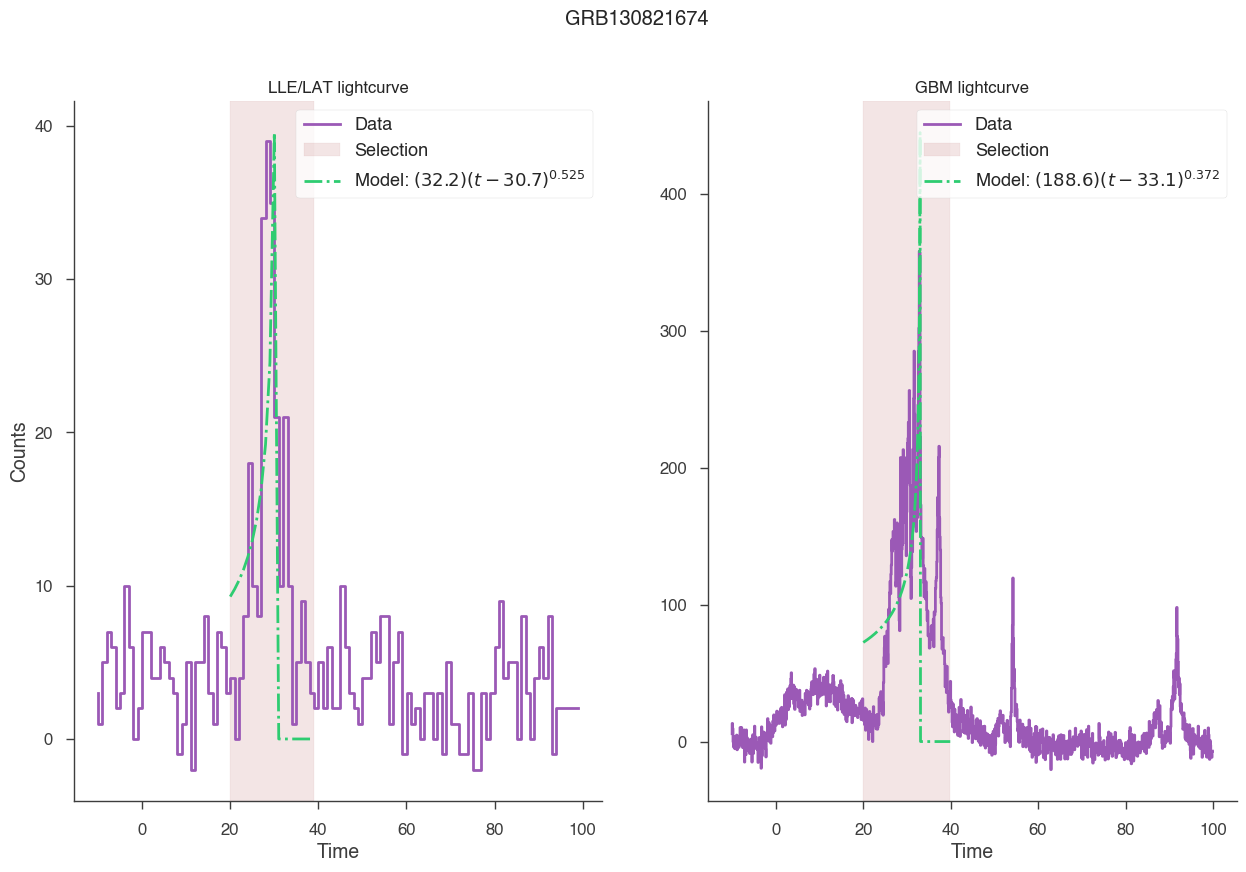

In [29]:
fig, ax = plt.subplots(1,2)

# Plot LLE data
ax[0].step(LAT_13_data['Start'], LAT_13_data['Counts'] - LAT_13_selection['Min sub'], label='Data')
ax[0].axvspan(LAT_13_selection['Time'].iloc[0], LAT_13_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred', label = 'Selection')



# Plot GBM data
ax[1].step(GBM_13_data['Start'], GBM_13_data['AvgCounts'] - GBM_13_selection['Min sub'], label = 'Data')
ax[1].axvspan(GBM_13_selection['Time'].iloc[0], GBM_13_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred', label = 'Selection')


# Plot LAT model
results = 32.2, .525, 30.7#42.8, .734, 31.
model = simplified_lightcurve(LAT_13_selection['Time'], *results)
labelstr = r'Model: $(%s)(t-%s)^{%s}}$'%(results[0], results[2], results[1])#, r2_score(GBM_10_selection['Data'], model))
ax[0].plot(LAT_13_selection['Time'], model, '-.', label = labelstr)

# Plot GBM model 
results =  188.6, .372, 33.1#191., 0.40, 33.1
model = simplified_lightcurve(GBM_13_selection['Time'], *results)#205., .426, 33.1)
labelstr = r'Model: $(%s)(t-%s)^{%s}$'%(results[0], results[2], results[1])
ax[1].plot(GBM_13_selection['Time'], model, '-.', label = labelstr)


fig.set_figwidth(15)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_title('LLE/LAT lightcurve')
ax[1].set_title('GBM lightcurve')

fig.suptitle('GRB130821674')
fig.savefig('Fitted_GRB130821674.png', dpi=500)

# GRB 100116897

In [32]:
### For the LLE
LAT_10_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/LAT_GRB100116897')

# Select bounds
LAT_signal_bounds = (0.,0.)
LAT_index_bounds = [np.argmin(np.abs(np.array(LAT_10_data['Start'])-i)) for i in LAT_signal_bounds]

# Snippet
time = LAT_10_data['Start'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()
data = LAT_10_data['Counts'][LAT_index_bounds[0]:LAT_index_bounds[1]].copy()

# Shift down for bkg
LAT_sub = data.min()

# Bring down to min
data -= LAT_sub

# Pack it away for plotting later
LAT_10_selection = {
    'Dataset': LAT_10_data,
    'Time': time,
    'Index bounds': LAT_index_bounds,
    'Min sub': LAT_sub
}


### For the GBM
GBM_10_data = pd.read_csv('../Lightcurve_Download/prelim_top_3_Data/GBM_GRB100116897')

# Select bounds
GBM_signal_bounds = (-5.,10.)
GBM_index_bounds = [np.argmin(np.abs(np.array(GBM_10_data['Start'])-i)) for i in GBM_signal_bounds]

# Snippet
time = GBM_10_data['Start'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()
data = GBM_10_data['AvgCounts'][GBM_index_bounds[0]:GBM_index_bounds[1]].copy()

# Shift down for bkg
GBM_sub = data.min()

# Bring down to min
data -= GBM_sub

GBM_10_selection = {
    'Dataset': GBM_10_data,
    'Time': time,
    'Data': data,
    'Index bounds': GBM_index_bounds,
    'Min sub': GBM_sub
}

def prior_10_GBM(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1e1
    hi = 1e3
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .372
    lo = .344
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = -5
    lo = 10
    params[2] = cube[2] * (hi - lo) + lo

    return params

if True:
    sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_10_GBM)

    result = sampler.run()
    sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+05  ..-549457.94 [-549458.1829..-549458.1828]*| it/evals=15471/41752 eff=37.4129% N=400     
[ultranest] Likelihood function evaluations: 41753
[ultranest]   logZ = -5.495e+05 +- 0.2121
[ultranest] Effective samples strategy satisfied (ESS = 2431.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.18 to 0.52, need <0.5)
[ultranest]   logZ error budget: single: 0.28 bs:0.21 tail:0.01 total:0.21 required:<0.50
[ultranest] done iterating.

logZ = -549492.184 +- 0.329
  single instance: logZ = -549492.184 +- 0.281
  bootstrapped   : logZ = -549492.232 +- 0.329
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 32.492│ ▁▁▁▁▁▁▁▁▁▂▂▂▄▅▅▇▇▇▇▇▇▆▆▄▃▃▂▂▁▁▁▁▁▁▁ ▁ │32.696    32.594 +- 0.025
    lc_index            : 0.3440000│▇▆▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

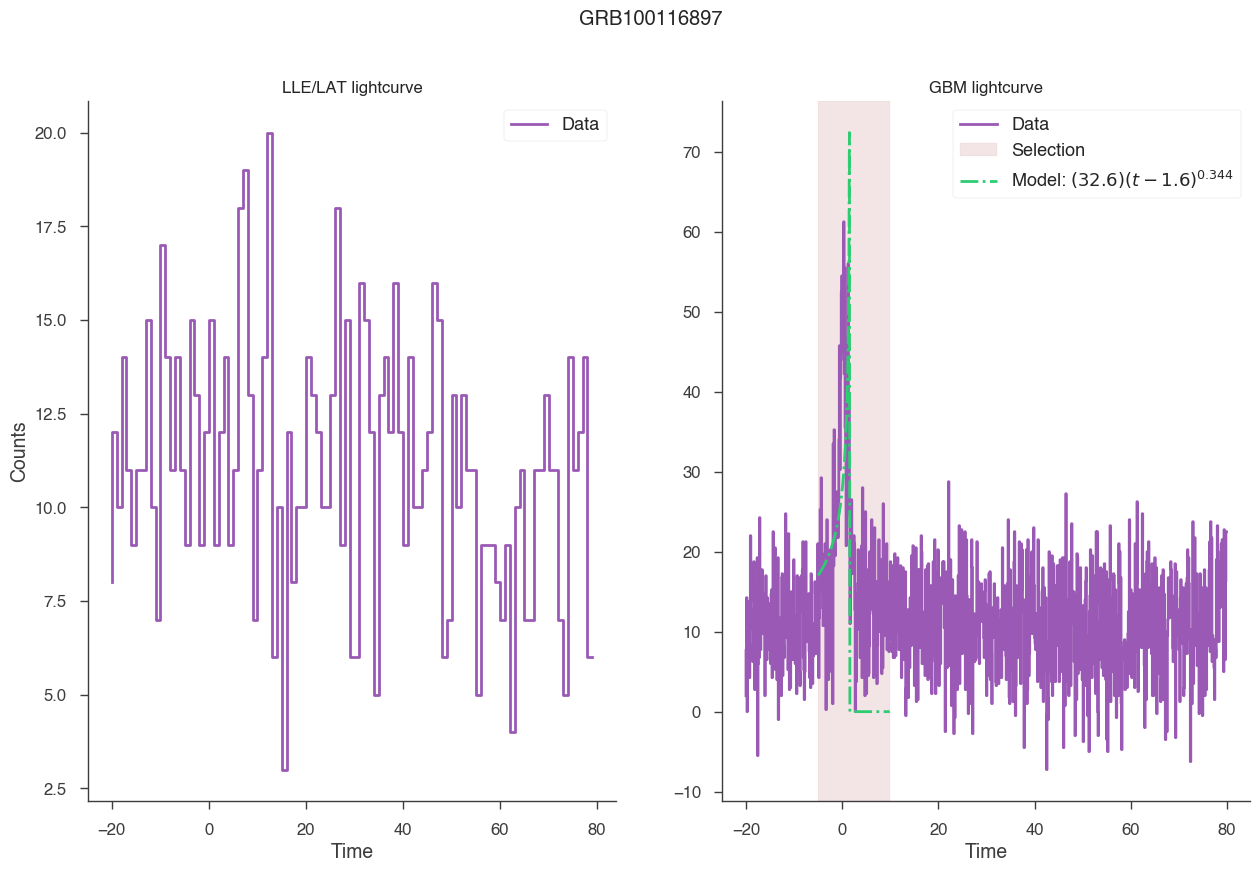

In [33]:
fig, ax = plt.subplots(1,2)

# Plot LLE data
ax[0].step(LAT_10_data['Start'], LAT_10_data['Counts'], label = 'Data')# - LAT_10_selection['Min sub'])
#ax[0].axvspan(LAT_14_selection['Time'].iloc[0], LAT_14_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred')

# Plot GBM data
ax[1].step(GBM_10_data['Start'], GBM_10_data['AvgCounts'] - GBM_10_selection['Min sub'], label = 'Data')
ax[1].axvspan(GBM_10_selection['Time'].iloc[0], GBM_10_selection['Time'].iloc[-1], alpha=0.1, color = 'darkred', label = 'Selection')


# Plot LAT model
#model = simplified_lightcurve(LAT_10_selection['Time'], 94.5, 0.76, 10.)#100.5, .771, 10)
#ax[0].plot(LAT_10_selection['Time'], model, '-.', label='model')

# Plot GBM model 
results = 32.6, .344, 1.6#32.2, .40, 1.6
model = simplified_lightcurve(GBM_10_selection['Time'], *results)
labelstr = r'Model: $(%s)(t-%s)^{%s}}$'%(results[0], results[2], results[1])#, r2_score(GBM_10_selection['Data'], model))
ax[1].plot(GBM_10_selection['Time'], model, '-.', label = labelstr)
ax[1].legend()

fig.set_figwidth(15)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_title('LLE/LAT lightcurve')
ax[1].set_title('GBM lightcurve')

fig.suptitle('GRB100116897')
fig.savefig('Fitted_GRB100116897.png', dpi=500)

-----
### Further investigation into the top 3

pre- and after-glow (ag) -- let the fit decide where the afterglow peak is

7-parameter problem: lc_norm, lc_index, lc_location, ag_norm, ag_A, ag_B, ag_delta


normalization should be similar for both lc and ag

check goodness-of-fit of lc without ag to contrast




Stefano is going to use Blackhawc to redo PBH calculations for T90 and Hardness


In [110]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

data_directory = './~100ms_Source_Data/'

param_names = ['lc_K', 'lc_index', 'lc_delta', 
'ag_K', 'ag_t_m', 'ag_t_p', 'ag_delta']

def lightcurve_model(params):

    # Retrieve new parameters
    (lc_K, lc_index, lc_delta, 
    ag_K, ag_t_m, ag_t_p, ag_delta) = params

    # Instantiate blank model
    model = np.zeros(len(data))

    # Create lc from simplified powerlaw model.
    model = model + simplified_lightcurve(tau = time,
     normalization = lc_K, index = lc_index, delta = lc_delta)

    # Create ag.
    model = model + afterglow(tau=time,
     normalization=ag_K, t_m = ag_t_m, t_p = ag_t_p, delta = ag_delta)

    return model

simplified_model = lambda params: simplified_lightcurve(tau = time, normalization=params[0], index=params[1], delta=params[2])

def likelihood_model(params):
    
    curve = lightcurve_model(params)
    
    like = -0.5 * (((curve - data)/1e2)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

simple_likelihood_model = lambda params: -0.5*(((simplified_model(params)-data)/np.mean(data)*.1)**2).sum()

In [113]:
GRBNAME = 'GRB141222298'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-1)
out_index = list(time).index(4)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Create Likelihood evaluation fcn.
poisson_likelihood_model = lambda params: -0.5 * ((
    (lightcurve_model(params) - data)
    /(0.5*data)) **2).sum()

# Define priors.
def prior_1412(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1000
    hi = 1500
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .9
    lo = .4
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = .2
    lo = -.1
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 7*1e3
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = 1e-1
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = .7 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = .7
    lo = 0
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

def prior_simple(cube):
    params = cube.copy()

    # lc_K: uniform
    lo = 1e2
    hi = 1e4
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    params[1] = norm.ppf(cube[1], .52, 1)

    # lc_delta: gaussian on the time w peak index
    params[2] = norm.ppf(cube[1], -time[peak_index], 1)

    return params

#param_names = ['lc_K', 'lc_index', 'lc_delta']

In [115]:
sampler = ultranest.ReactiveNestedSampler(param_names, poisson_likelihood_model, prior_1412)#simple_likelihood_model, prior_simple)#

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 

0.7134216172757318


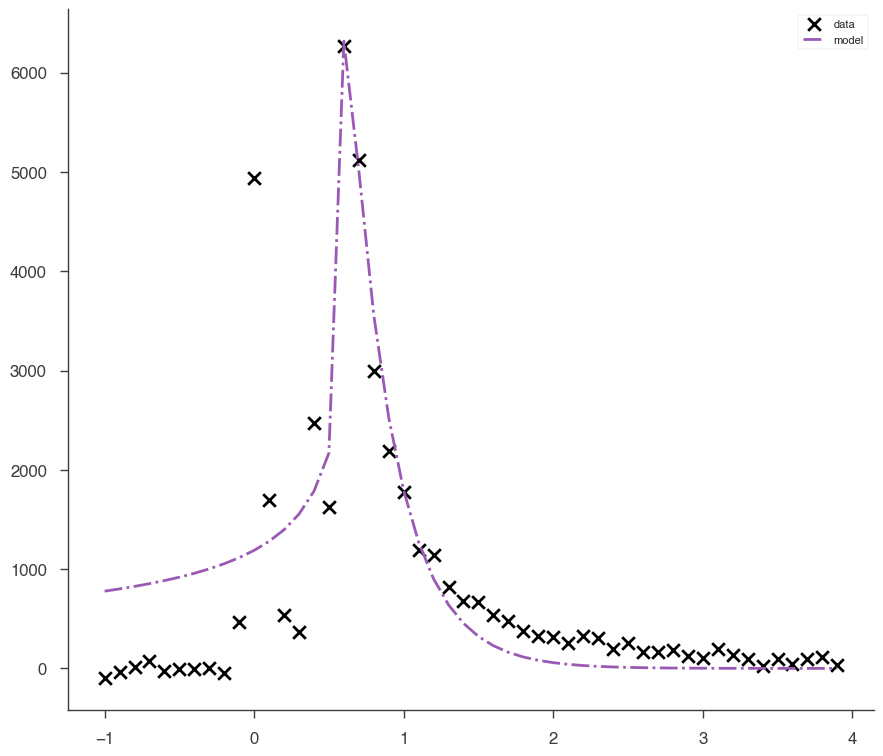

In [18]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #1253, .63, .1, 9500, .051, .35, .5
    1001.6, .477, .6979, 7039, .0091, .2914, .6013
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()

print(r2_score(data, model))

In [19]:
GRBNAME = 'GRB131014215'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-1)
out_index = list(time).index(8)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Define priors.
def prior_1310(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1000
    hi = 5000
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .9
    lo = .4
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 2
    lo = 1
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 1e5
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = 1e-1
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = 2 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = 2
    lo = 1
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

In [10]:
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_1310)#simple_likelihood_model, prior_simple)#

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+05  -99120.20 [-99121.2268..-99121.2263]*| it/evals=26680/332269 eff=8.0393% N=400    
[ultranest] Likelihood function evaluations: 332276
[ultranest]   logZ = -9.918e+04 +- 0.3171
[ultranest] Effective samples strategy satisfied (ESS = 3582.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.27 to 0.69, need <0.5)
[ultranest]   logZ error budget: single: 0.38 bs:0.32 tail:0.01 total:0.32 required:<0.50
[ultranest] done iterating.

logZ = -99183.069 +- 0.694
  single instance: logZ = -99183.069 +- 0.379
  bootstrapped   : logZ = -99183.064 +- 0.694
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 1000.00│▇▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁    ▁ │1002.57    1000.21 +- 0.21
    lc_index            : 0.89498│ ▁  ▁▁ ▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂

0.7021865837985328


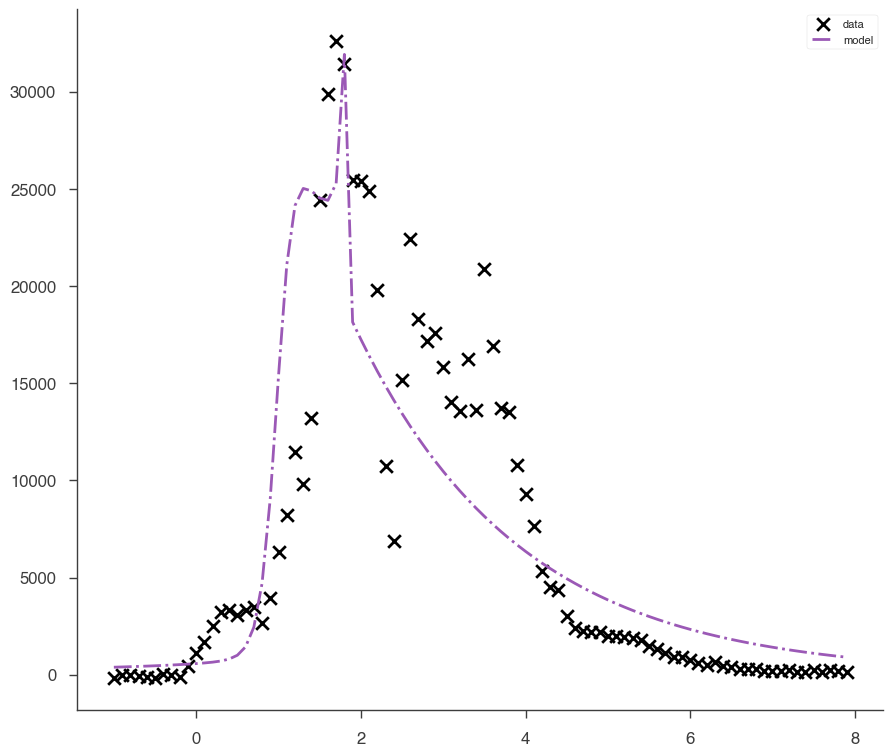

In [20]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #3500, .7, 1.8, 3.5*1e4, .1, 1.3, 1.7
    1000.21, .89953, 1.85853, 28460, .0999944, 1.999973, .999954
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()

print(r2_score(data, model))

In [60]:
GRBNAME = 'GRB140102887'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-2)
out_index = list(time).index(8)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Define priors.
def prior_1401(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 500
    hi = 2000
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    lo = .4
    hi = .9
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    lo = .6
    hi = .9
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 1e2
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = .3
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = 1 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = 2.5
    lo = 2
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

In [91]:
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_1401)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+03  094.35 [-6095.0291..-6095.0290]*| it/evals=15430/230938 eff=6.6930% N=400 
[ultranest] Likelihood function evaluations: 230939
[ultranest]   logZ = -6129 +- 0.1963
[ultranest] Effective samples strategy satisfied (ESS = 3169.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.17 to 0.50, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -6128.810 +- 0.502
  single instance: logZ = -6128.810 +- 0.274
  bootstrapped   : logZ = -6128.744 +- 0.502
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 500   │▁▁▁▁▂▂▂▃▄▅▆▆▇▇▇▇▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁  ▁▁ │597       536 +- 12
    lc_index            : 0.8319│ ▁        ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▇│0.9000    0.8922 +-

0.6


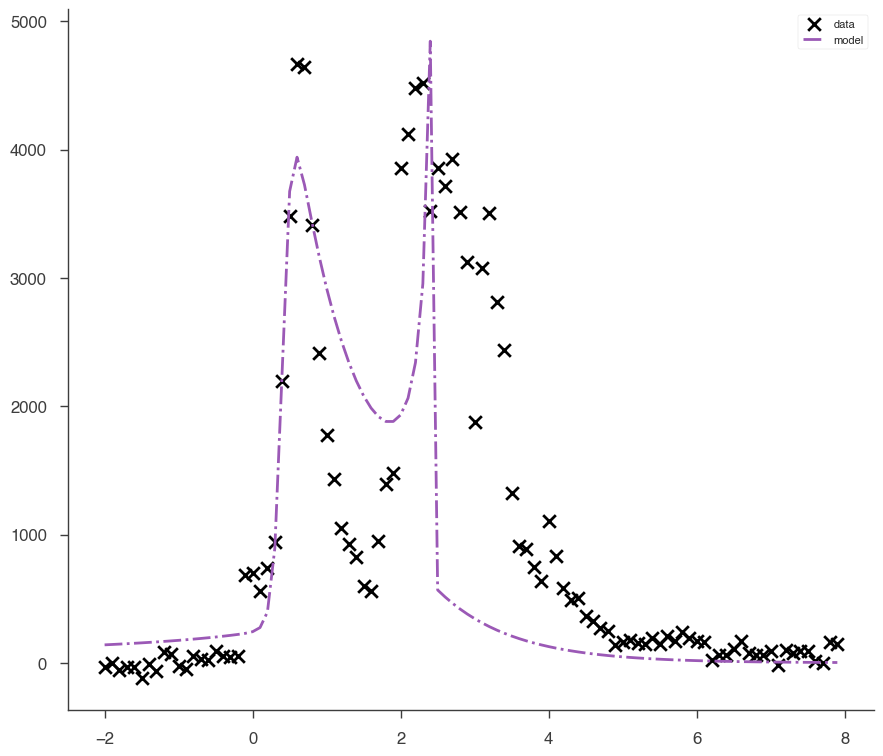

In [61]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #1000, .7, .8, 8800, .2, .6, 2.3
    536, .892, 2.499, 4566, .0589, .9995, .4159
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()
print(time[peak_index])